In [1]:
## Notebook env: brian_script_env (R kernel)

## Run Finding_variable_genes_ipynb before running this script
### This script measures if a given guide's cells see increased or decreased
### gene expression heterogeneity compared to control cells)

### Coefficient of Variation (CV) or Mutant-Allele Tumor Heterogeneity (MATH)
### are used to quantify heterogeneity depending on the analysis variant used

In [2]:
## things to shift:
## increase fixed number of cells used

In [3]:
## things to adjust:
## stringency of initial gene filter (lower it?) DONE
## expand gene analysis to beyond top 2000 var genes DONE
## remove random_TuD_NC from z-score calculations (should be fixed after making sure all guides use 30 cells)
## use less stringent method to calculate q-values or some other analagous method that is less stringent on p-value correction (this will lead to more genes being usable for analysis)
## use MATH to calculate variation shift instead of CV
## # of cells per guide

In [1]:
## This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#### EDIT THIS CELL TO ANNOTATE EACH NOTEBOOK VARIANT ####
## This nb variant uses CV to quantify gene heterogeneity of all genes

variant = 'CV_top2000var_normalized_mtx_'

In [2]:
library(ggplot2)
library(stringr)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Seurat)
library(Matrix)
library(sparseMatrixStats)
library(dplyr)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
assignments_CRISPRi = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/geomux_output_assignments_CRISPRi.csv')

In [4]:
CRISPRi_screen = Read10X_h5('/home/ssobti/projects/heterogeneity_brian/data/032923_MD231_CRISPRi_CRISPRa_screen/230329_A01102_0587_AH3CY5DSX7_S4_200/cellranger/combined_G12/outs/count/filtered_feature_bc_matrix.h5')

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Genome matrix has multiple modalities, returning a list of matrices for this genome



In [5]:
CRISPRi_seurat = CreateSeuratObject(CRISPRi_screen[['Gene Expression']])

In [6]:
CRISPRi_seurat = CRISPRi_seurat[,assignments_CRISPRi$barcode]

In [7]:
CRISPRi_seurat@meta.data = cbind(CRISPRi_seurat@meta.data, select(assignments_CRISPRi, -c('barcode', 'barcode.1')))
CRISPRi_guides_to_keep_and_analyze = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/CRISPRi_guides_to_keep_and_analyze.csv')

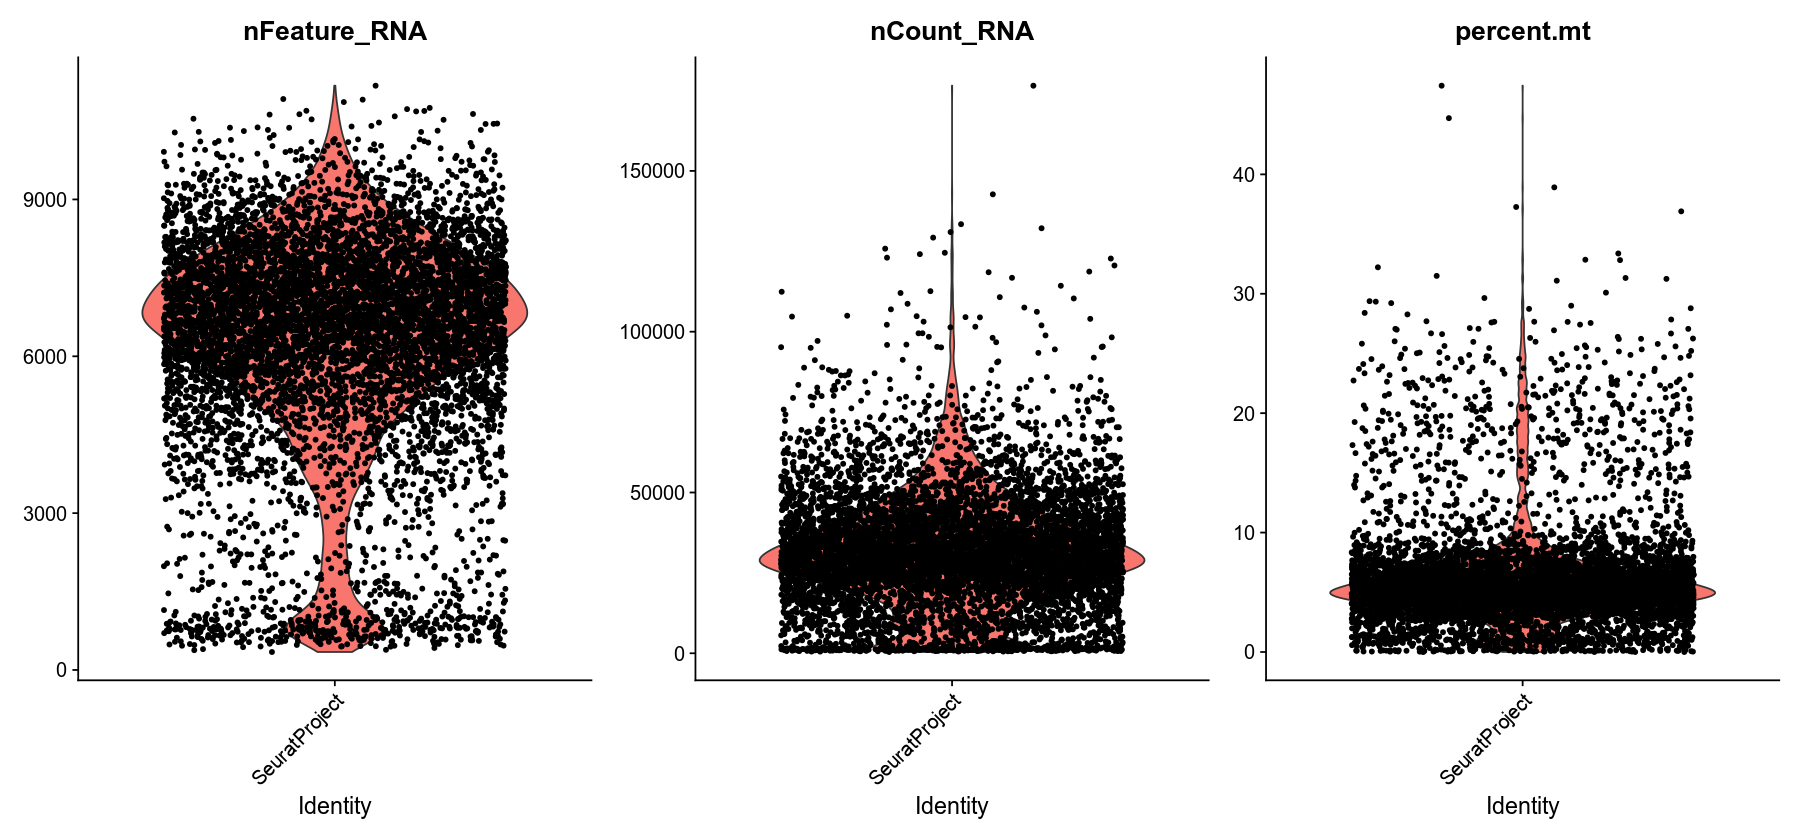

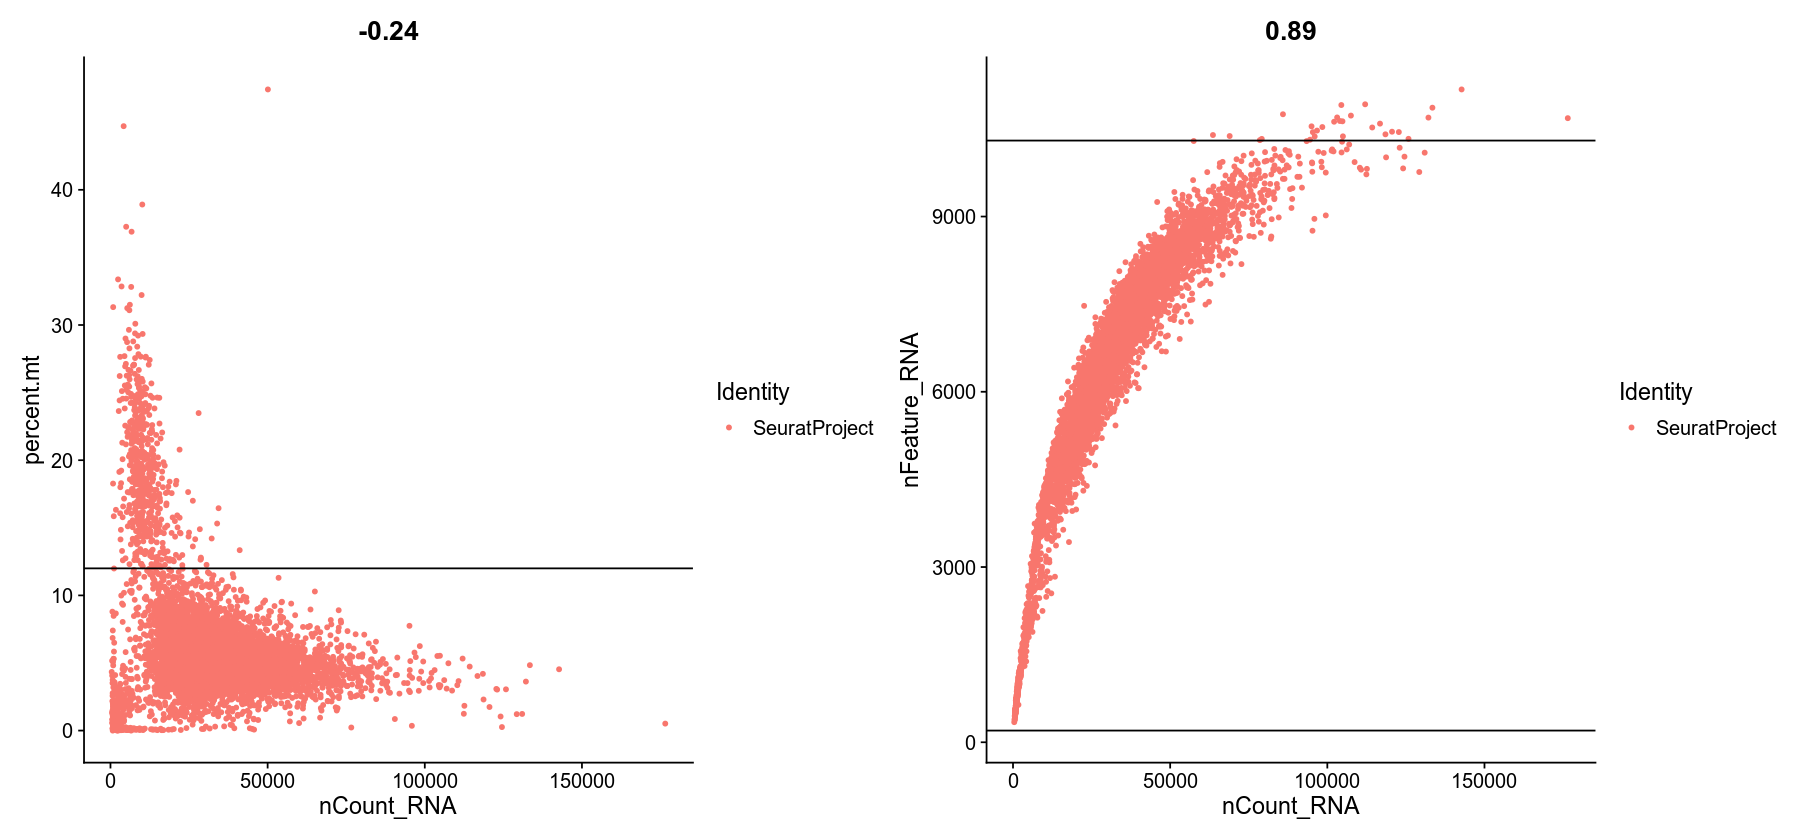

In [8]:
options(repr.plot.width=15, repr.plot.height=7)
CRISPRi_seurat[["percent.mt"]] <- PercentageFeatureSet(CRISPRi_seurat, pattern = "^MT-")
VlnPlot(CRISPRi_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(CRISPRi_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_hline(yintercept = 12)
plot2 <- FeatureScatter(CRISPRi_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_hline(yintercept = 200) + geom_hline(yintercept = 10300)
plot1 + plot2

In [9]:
#CRISPRi_seurat <- subset(CRISPRi_seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 10300 & percent.mt < 12)
suppressWarnings({CRISPRi_seurat <- SCTransform(CRISPRi_seurat, vars.to.regress = "percent.mt", verbose = FALSE)})

In [10]:
variable_genes_df = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/top_var_genes.csv')
top_variable_genes = as.character(variable_genes_df$variable_genes)
head(top_variable_genes)

[1] "IFIT1"   "IFIT2"   "IFIT3"   "CST1"    "ZC3HAV1" "OASL"

In [11]:
## only keep guides that were selected in Identifying_guides_with_high_knockdown.ipynb
CRISPRi_seurat = CRISPRi_seurat[, CRISPRi_seurat@meta.data$guide %in% c('NT-1i', 'NT-2i', 'NT-3i', 'NT-4i', 'NT-5i', as.character(CRISPRi_guides_to_keep_and_analyze$guide))]
CRISPRi_seurat@meta.data$guide <- stringr::str_sub(CRISPRi_seurat@meta.data$guide, start = 1, end = -4)

In [12]:
## removing any genes that are not in top 2000 most variable
top_variable_genes = rownames(CRISPRi_seurat@assays$SCT@scale.data)
filtered_meta_data <- CRISPRi_seurat@meta.data
filtered_raw_mtx <- CRISPRi_seurat@assays$SCT@data[top_variable_genes,]
filtered_meta_data <- filtered_meta_data[colnames(filtered_raw_mtx),]
colnames(filtered_raw_mtx) = rownames(filtered_meta_data)

In [13]:
### removing genes with medians < 1 keeps 22% of genes -- low expressing genes have noisy expression and confound results ###
##genes_to_keep = as.numeric(medians) >= 1
##filtered_raw_mtx <- filtered_raw_mtx[genes_to_keep,]
##filtered_meta_data <- filtered_meta_data[colnames(filtered_raw_mtx),]

In [14]:
## cells per guide count
guides = unique(filtered_meta_data$guide)

cells_per_guide = vector()
for (i in 1:length(guides)){
    cells_per_guide[i] = length(which(filtered_meta_data$guide == guides[i]))
}

cell_gd_count = data.frame(guide_name = guides, cell_count = cells_per_guide)



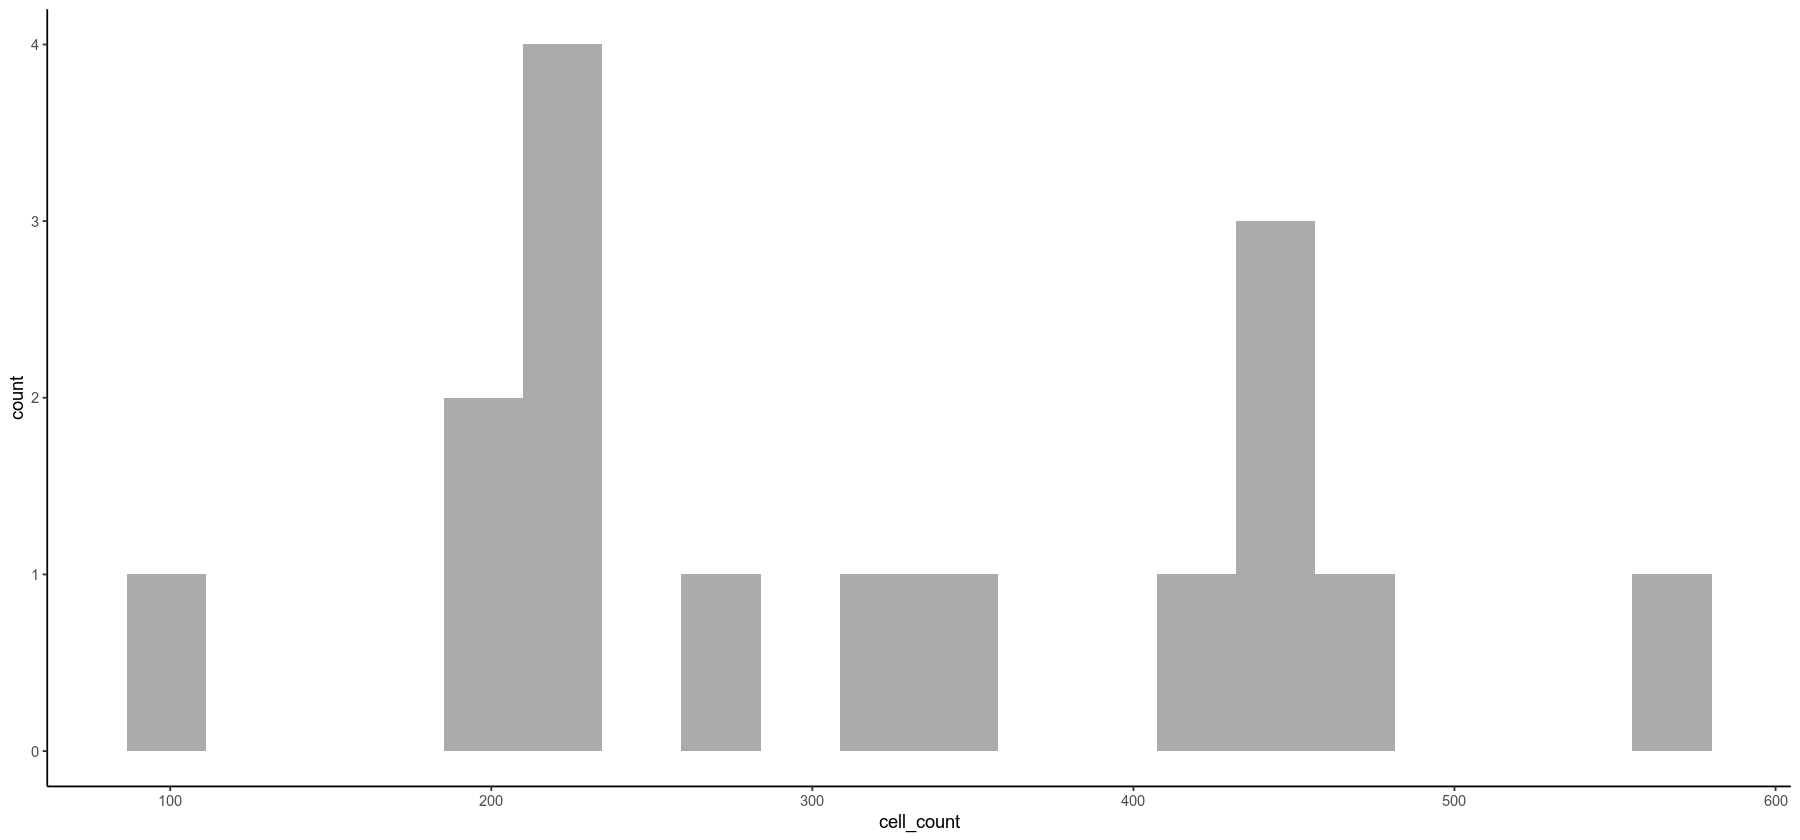

In [15]:
### show distribution of cells per guide

ggplot(cell_gd_count, aes(x=cell_count)) +
geom_histogram(position="identity", alpha=0.5, bins = 20) +
theme_classic()


In [16]:
arrange(cell_gd_count, cell_count)

guide_name,cell_count
<fct>,<int>
AURKB,90
CENPN,187
CDK1,192
HJURP,212
SUPV3L1,216
AURKA,227
ENY2,232
RUVBL1,274
CENPM,328


In [17]:
### divide expression mtx into a list of mtxs subsetted by guide

mtx_subsetter = function(guide_nm, matrix, meta_data){
    return(matrix[, meta_data$guide == guide_nm])}

guide_subsetted_data = pblapply(X = guides, FUN = mtx_subsetter, 
                                matrix = filtered_raw_mtx, meta_data = filtered_meta_data)

names(guide_subsetted_data) = guides

In [18]:
## control number of cells per guide to be equivalent
## throw out guides with < 90 cells and for the remaining guides sample 60 cells without replacement
fixed_cell_count = 90
guide_subsetted_data = guide_subsetted_data[cells_per_guide >= fixed_cell_count]
cells_to_discard = list()

set.seed(22)
for (i in 1:length(guide_subsetted_data)){
    idx_to_keep = sample(1:ncol(guide_subsetted_data[[i]]), fixed_cell_count, replace = FALSE)
    idx_to_discard = setdiff(1:ncol(guide_subsetted_data[[i]]), idx_to_keep)
    cells_to_discard[[i]] = colnames(guide_subsetted_data[[i]])[idx_to_discard]
    guide_subsetted_data[[i]] = guide_subsetted_data[[i]][,idx_to_keep]
}

cells_to_discard = unlist(cells_to_discard)

In [19]:
## add bkg distribution of guide subsetted mtxs to list
## this is just mtxs where the cells are randomly assigned to each guide
## the bkg distribution of mtxs is made to subtract out number of genes that are expected to have increased or decreased CV when cells assigned randomly to each guide
## Note: the number of cells assigned to each guide is kept the same
set.seed(44)

randomized_filtered_raw_mtx = Reduce(cbind, guide_subsetted_data[names(guide_subsetted_data) != "NT"])
randomized_cell_order = sample(colnames(randomized_filtered_raw_mtx), ncol(randomized_filtered_raw_mtx), replace = FALSE)


designation_vector = mapply(rep, guides[guides != 'NT'], fixed_cell_count, SIMPLIFY = TRUE)
designation_vector = unlist(designation_vector)
designation_vector = as.character(designation_vector)
split_barcodes = split(randomized_cell_order, designation_vector)
mtx_random_splitter = function(barcodes, mtx){return(mtx[,barcodes])}

guide_random_subsetted_data = pblapply(X = split_barcodes, FUN = mtx_random_splitter, mtx = randomized_filtered_raw_mtx)
guide_random_subsetted_data = c(guide_subsetted_data[names(guide_subsetted_data) == "NT"], guide_random_subsetted_data)
names(guide_random_subsetted_data) = paste('random', guides, sep = '_')

In [20]:
guide_subsetted_data = c(guide_subsetted_data, guide_random_subsetted_data)

In [21]:
## compare each of the guide subsetted data to the control subsetted data and
## create the following table for each guide:
## gene | CV1 (ctrl) | CV2 (gd) | CV2/CV1 | Increasing or Decreasing CV (ie CV2/CV1 > 1 or CV2/CV1 < 1) | asymptotic test p-value | q-value 


## CV calculator
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs = pblapply(X = guide_subsetted_data, FUN = CV_calculator)
names(CVs) = names(guide_subsetted_data)

In [22]:
### creating first 4 columns of the table annotated above
gene_means = lapply(guide_subsetted_data, sparseMatrixStats::rowMeans2)
gene_sds = lapply(guide_subsetted_data, sparseMatrixStats::rowSds)
names(gene_means) = names(guide_subsetted_data)
names(gene_sds) = names(guide_subsetted_data)


master_df_list = list()
for (i in 1:length(guide_subsetted_data)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NT']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NT']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NT']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NT']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
}



In [23]:
### creating column 5 of the table annotated above
for (i in 1:length(master_df_list)){
    master_df_list[[i]]$gene_status = 'NA'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio == 1] = 'No Change'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio > 1] = 'Increasing'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio < 1] = 'Decreasing'               
}


In [24]:
## performing CV equality aysmptotic test and adding its pval to master_df_list
cells_per_guide = rep(cells_per_guide, 2)
names(cells_per_guide) = names(guide_subsetted_data)
asymp_test_p_vals = as.data.frame(matrix(0, nrow = nrow(filtered_raw_mtx), ncol = length(master_df_list)))


for (i in 1:length(master_df_list)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NT'], cells_per_guide[i]), s = c(gene_sds[['NT']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NT']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NT'], cells_per_guide[i]), s = c(gene_sds[['NT']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NT']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }    
    }
    master_df_list[[i]]$p_val = asymp_test_p_vals[,i]
}

In [25]:
## ***
## pick relevant assay in FindMarkers
## Find genes that see a significant change in mean from NT control
pbo = pboptions(type="txt")
cells_to_keep_from_fixed_cell_count <- colnames(Reduce(cbind, guide_subsetted_data[guides]))


Idents(object = CRISPRi_seurat) <- CRISPRi_seurat@meta.data$guide
CRISPRi_seurat = CRISPRi_seurat[top_variable_genes, cells_to_keep_from_fixed_cell_count]

find_markers_wrapper = function(perturbed_gene){
                                      FindMarkers(CRISPRi_seurat, ident.1 = 'NT', ident.2 = perturbed_gene, test.use = 't', verbose = FALSE)
}

mean_shifts_from_NT = pblapply(guides[guides != 'NT'], find_markers_wrapper)
names(mean_shifts_from_NT) = guides[guides != 'NT']

## Find genes that see signinficant change in mean from control in bkg (randomized cell labels)

CRISPRi_seurat_random = CRISPRi_seurat
meta_temp = CRISPRi_seurat_random@meta.data
meta_temp[randomized_cell_order, 'guide'] = designation_vector
CRISPRi_seurat_random@meta.data = meta_temp

find_markers_wrapper_random = function(perturbed_gene){
                                      FindMarkers(CRISPRi_seurat_random, ident.1 = 'NT', ident.2 = perturbed_gene, test.use = 't',verbose = FALSE)
}

mean_shifts_from_NT_bkg = pblapply(guides[guides != 'NT'], find_markers_wrapper_random)
names(mean_shifts_from_NT_bkg) = paste('random', sep = '_', guides[guides != 'NT'])

mean_shifts_from_NT = c(mean_shifts_from_NT, mean_shifts_from_NT_bkg)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%


In [26]:
## Converting p-values to q-values and adding to master_df_list

for (i in 1:length(master_df_list)){
    q_vals = qvalue(master_df_list[[i]]$p_val, fdr.level = 0.05)
    master_df_list[[i]]$q_val = q_vals$qvalues
}

master_df_list[c('NT', 'random_NT')] <- NULL
guide_subsetted_data[c('NT', 'random_NT')] <- NULL

In [27]:
## ***
## Count number of CV_gdCV_ctrlratio genes > 1 (ie gene_status 'Increasing') with q-val < 0.05
## Count number of CV_gdCV_ctrlratio genes < 1 (ie gene_status 'Decreasing') with q-val < 0.05
filtered_master_df_list = lapply(master_df_list, dplyr::filter, q_val < 0.05)
filtered_mean_shifts_from_NT = lapply(mean_shifts_from_NT, dplyr::filter, p_val_adj < 0.05)
genes_with_shift_in_mean = lapply(filtered_mean_shifts_from_NT, rownames)

## remove genes that see significant change in mean from NT from increase/decrease counts in filtered_master_df_list

for (i in 1:length(filtered_master_df_list)){
    if (length(genes_with_shift_in_mean[[i]]) > 0){
        intersection = intersect(genes_with_shift_in_mean[[i]], filtered_master_df_list[[i]]$gene)
        if (length(intersection) > 0){
            filtered_master_df_list[[i]] = filtered_master_df_list[[i]][!(filtered_master_df_list[[1]]$gene %in% intersection),]
        }
    }
}

## counting genes with change in CV

gene_status_list = lapply(filtered_master_df_list, '[[', 'gene_status')

count_increasing = function(x){length(which(x == 'Increasing'))}
count_decreasing = function(x){length(which(x == 'Decreasing'))}

number_of_increasing_CV_genes = sapply(gene_status_list, count_increasing)
number_of_decreasing_CV_genes = sapply(gene_status_list, count_decreasing)

metric_change_df = data.frame(guide = names(master_df_list), increasing_CV_genes = number_of_increasing_CV_genes, decreasing_CV_genes = number_of_decreasing_CV_genes)

In [28]:
## z-score each guide by the following formula:
## (# of genes increased CV in guide - mean(# of genes increased CV bkg))/sd(# of genes increased CV bkg)
## (# of genes decreased CV in guide - mean(# of genes decreased CV bkg))/sd(# of genes decreased CV bkg)

increasing_random_vals = metric_change_df$increasing_CV_genes[startsWith(rownames(metric_change_df), 'random')]
metric_change_df$z_score_increasing_genes = (metric_change_df$increasing_CV_genes - mean(increasing_random_vals)) / sd(increasing_random_vals)

decreasing_random_vals = metric_change_df$decreasing_CV_genes[startsWith(rownames(metric_change_df), 'random')]
metric_change_df$z_score_decreasing_genes = (metric_change_df$decreasing_CV_genes - mean(decreasing_random_vals)) / sd(decreasing_random_vals)

In [29]:
path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'metric_change_df.csv')
write.csv(metric_change_df, file = path)

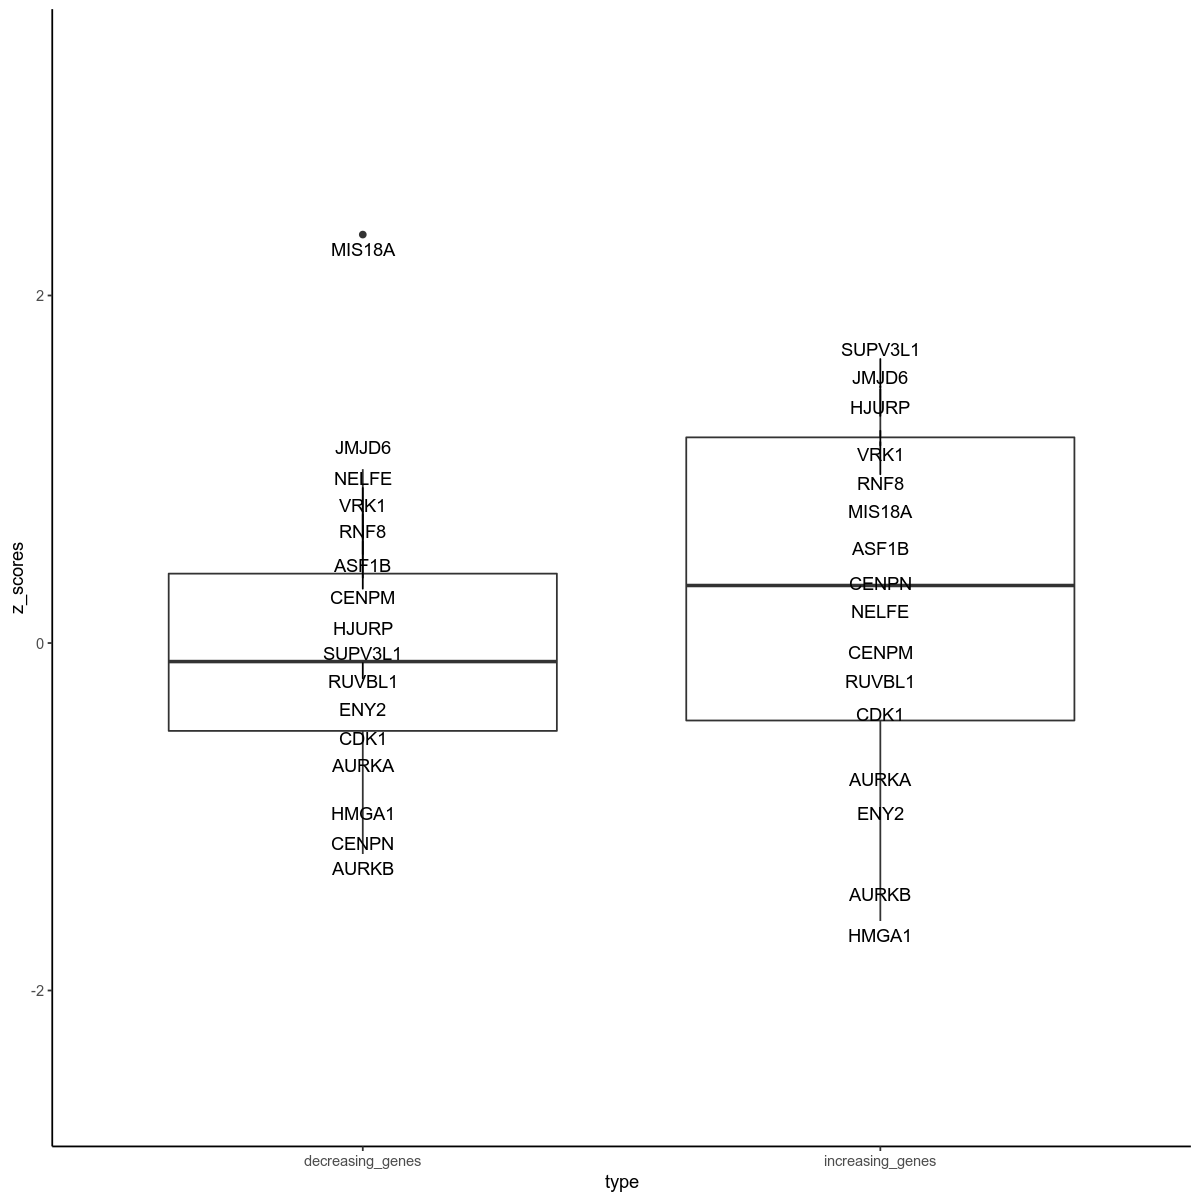

In [30]:
## graph z-scores of increasing CV of each of the guides as boxplot, show top ones. Also show z-scores of decreasing CV
options(repr.plot.width=10, repr.plot.height=10)
graphing_z_score_df = metric_change_df[!startsWith(rownames(metric_change_df), 'random'),]
graphing_z_score_df = tidyr::pivot_longer(graphing_z_score_df, cols = starts_with("z_score"), names_to = "type", names_prefix = "z_score_", values_to = "z_scores")
graphing_z_score_df = as.data.frame(graphing_z_score_df)
path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'graphing_z_score_df.csv')
write.csv(graphing_z_score_df, file = path)
graphing_z_score_df = read.csv(path)

library(ggplot2)
library(ggrepel)

ggplot(graphing_z_score_df, aes(x=type, y=z_scores)) + 
    geom_boxplot() + scale_fill_brewer(palette="Blues") + geom_text_repel(aes(y = z_scores, x = type, label = guide), direction = "y") +
    theme_classic() + ylim(min(graphing_z_score_df$z_scores) - 1, max(graphing_z_score_df$z_scores) + 1)

In [31]:
metric_change_df$number_of_increasing_CV_genes_minus_random = metric_change_df$increasing_CV_genes - mean(increasing_random_vals)
metric_change_df$number_of_decreasing_CV_genes_minus_random = metric_change_df$decreasing_CV_genes - mean(decreasing_random_vals)
metric_change_df$number_of_net_decreasing_CV_genes = metric_change_df$number_of_decreasing_CV_genes_minus_random - metric_change_df$number_of_increasing_CV_genes_minus_random

In [32]:
graphing_gene_numbers_df = metric_change_df[!startsWith(rownames(metric_change_df), 'random'),]
graphing_gene_numbers_df = tidyr::pivot_longer(graphing_gene_numbers_df, cols = starts_with("number"), names_to = "type", names_prefix = "number_of_", values_to = "number_of_genes")
graphing_gene_numbers_df = as.data.frame(graphing_gene_numbers_df)

png 
  2

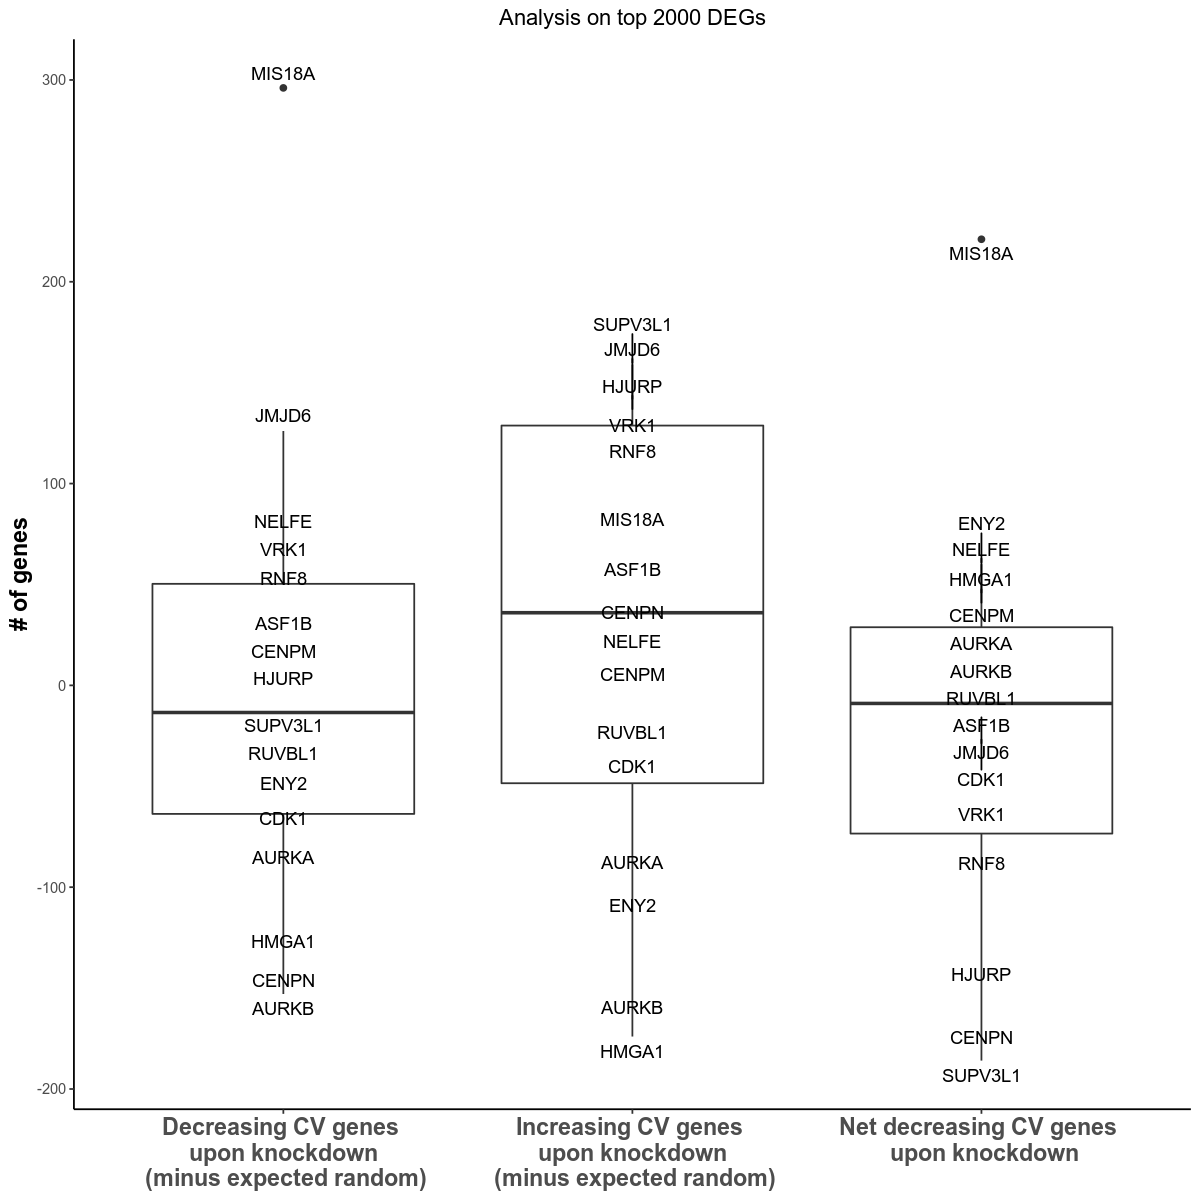

In [33]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(graphing_gene_numbers_df, aes(x=type, y=number_of_genes)) + ggtitle('Analysis on top 2000 DEGs') +
    geom_boxplot() + scale_fill_brewer(palette="Blues") + geom_text_repel(aes(y = number_of_genes, x = type, label = guide), direction = "y") +
    scale_x_discrete(labels=c("Decreasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Increasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Net decreasing CV genes \n upon knockdown")) + ylab('# of genes') +
    theme_classic() + theme(axis.title.x=element_blank(), axis.text.x = element_text(size = 14, face = 'bold'), axis.title.y = element_text(size = 14, face = 'bold'), plot.title = element_text(hjust = 0.5))

path = paste0('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/', variant, 'gene_shifts.pdf')

pdf(path, width = 10, height = 10)
ggplot(graphing_gene_numbers_df, aes(x=type, y=number_of_genes)) + ggtitle('Analysis on top 2000 DEGs') +
    geom_boxplot() + scale_fill_brewer(palette="Blues") + geom_text_repel(aes(y = number_of_genes, x = type, label = guide), direction = "y") +
    scale_x_discrete(labels=c("Decreasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Increasing CV genes \n upon knockdown \n (minus expected random)", 
                              "Net decreasing CV genes \n upon knockdown")) + ylab('# of genes') +
    theme_classic() + theme(axis.title.x=element_blank(), axis.text.x = element_text(size = 14, face = 'bold'), axis.title.y = element_text(size = 14, face = 'bold'), plot.title = element_text(hjust = 0.5))
dev.off()


In [ ]:
## most importantly see which guides have high z-scores in first graph and low in second 
## also which guides have low z-scores in first graph and high in second 

In [ ]:
### the next step could be a comparison between control cells
## and each guide vs comparison between control cells and guides grouped by seed sequence
## analagous to comparing magnitude of CV influence from q25/q75 analysis to q10/q90